# Comparing Methodologies

In [1]:
import sys
sys.path.append("../")
from lib.rs import research_space

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

### LOAD

In [3]:
key = "sjr"

In [4]:
rs_2011 = research_space(key)
rs_2011.load(2011)
rs_2011.set_institution("../../dataset/lattes/pesquisadores.csv", sep=";sep;")
rs_2011.advantages()
rs_2011.set_indicators()

In [5]:
ss_2011 = research_space(key)
ss_2011.load(2011)
ss_2011.load_star_space(200)
ss_2011.set_institution("../../dataset/lattes/pesquisadores.csv", sep=";sep;")
ss_2011.advantages()
ss_2011.set_indicators()

In [6]:
rs_2020 = research_space(key)
rs_2020.load(2020)
rs_2020.set_institution("../../dataset/lattes/pesquisadores.csv", sep=";sep;")
rs_2020.advantages()
rs_2020.set_indicators()

### ACCURACY

In [7]:
from collections import defaultdict

sumx = defaultdict(int)
sumi = defaultdict(int)
sume = defaultdict(int)

s = set(rs_2011.scientists)

for sf in rs_2011.x:
    if sf[0] not in s:
        continue

    ins = rs_2011.inst[sf[0]]
    est = rs_2011.est[sf[0]]

    sumi[ins] += rs_2011.x[sf]
    sume[est] += rs_2011.x[sf]
    sumx[sf[0]] += rs_2011.x[sf]
    
sums = [sumx, sumi, sume]

In [8]:
def accuracy(level, transition):
    # Translation
    dic = {x: rs_2020.fields.index(x) for x in rs_2011.fields}
    dic11 = {x: rs_2011.fields.index(x) for x in rs_2011.fields}
    rng = [rs_2011.scientists, set(x[0] for x in rs_2011.rca[1]), set(x[0] for x in rs_2011.rca[2])]
    u = 0 if transition == 'inactive-active' else 1
    
    if level == 'scientist':
        lev = 0
    elif level == 'institution':
        lev = 1
    elif level == 'state':
        lev = 2

    auc = [list(), list()]
    wins = [0,0,0]
    wins_over = [0,0,0]
    spearman = list()
    areas = [list(), list()]
    X = list()
    
    for s in rng[lev]:
        # Prediction
        pred = [0,0]
        pred[0] = rs_2011.predict(s, level, transition)
        pred[1] = ss_2011.predict(s, level, transition)
        rank = [set([x[1] for x in p]) for p in pred]
        
        # Add missing classes
        for i in [0, 1]:
            for j in [x for x in rank[not i] if x not in rank[i]]:
                pred[i].append((0.0, j))
                        
        # Ground truth
        true = [[1 if dic[x[1]] in rs_2020._U[lev][u][s] else 0 for x in p] for p in pred]
        if sum([1 for t in true if sum(t) == 0 or sum(t) == len(t)]) > 0:
            continue
        
        prob = [[x[0] for x in p] for p in pred]
        rank = [[x[1] for x in p] for p in pred]
        
        auc[0].append(roc_auc_score(true[0], prob[0]))
        auc[1].append(roc_auc_score(true[1], prob[1]))
        
        # Summary
        if auc[0][-1] > auc[1][-1]:
            wins[0] += 1
            if auc[1][-1] > 0.5:
                wins_over[0] += 1
        elif auc[0][-1] < auc[1][-1]:
            wins[1] += 1
            if auc[0][-1] > 0.5:
                wins_over[1] += 1
        else:
            wins[2] += 1
            if auc[1][-1] > 0.5:
                wins_over[2] += 1
        
        # Plot data
        n = len(true[0])
        spearman.append(1 - (6*sum((x - rank[1].index(rank[0][x]))**2 for x in range(n)))/(n*(n**2-1)))
        areas[0].append(sum([1 if dic11[x] in rs_2011._U[lev][0][s] else 0 for x in rs_2011.fields]))
        areas[1].append(sum([1 if dic11[x] in rs_2011._U[lev][1][s] else 0 for x in rs_2011.fields]))
        X.append(sums[lev][s])
        
    # Plots
    plt.rcParams["figure.figsize"] = (18,12)
    fp = dict(marker='o', markersize=5, linestyle='none', alpha=0.01)
    plt.subplot(2,3,1)
    plt.boxplot(auc, flierprops=fp)
    plt.title("{}: {}".format(level, transition))
    plt.ylabel('AOC ROC')
    plt.xticks([1, 2], ['RS', 'SS'])
    
    plt.subplot(2,3,2)
    plt.hist(spearman, density=True, bins=20)
    plt.title("Spearman Correlation Distribution")
    plt.ylabel('Densidade')
    
    plt.subplot(2,3,3)
    plt.scatter(auc[0], auc[1], color='orange', alpha=0.3)
    plt.title("Comparação entre previsões")
    plt.xlabel('RS')
    plt.ylabel('SS')
    
    plt.subplot(2,3,4)
    a = plt.scatter(areas[0], auc[0], color='green', alpha=0.3)
    b = plt.scatter(areas[0], auc[1], color='red', alpha=0.3)
    plt.xlabel('Número de áreas ativas')
    plt.ylabel('AOC ROC')
    plt.legend([a, b], ['RS', 'SS'])
    plt.title("Relação entre número de áreas ativas e predição")
    
    plt.subplot(2,3,5)
    a = plt.scatter(areas[1], auc[0], color='green', alpha=0.3)
    b = plt.scatter(areas[1], auc[1], color='red', alpha=0.3)
    plt.xlabel('Número de áreas desenvolvidas')
    plt.ylabel('AOC ROC')
    plt.legend([a, b], ['RS', 'SS'])
    plt.title("Relação entre número de áreas desenvolvidas e predição")
    
    plt.subplot(2,3,6)
    a = plt.scatter(X, auc[0], color='green', alpha=0.3)
    b = plt.scatter(X, auc[1], color='red', alpha=0.3)
    plt.xlabel('Número de publicações')
    plt.ylabel('AOC ROC')
    plt.legend([a, b], ['RS', 'SS'])
    plt.title("Relação entre número de publicações e predição")
    plt.show()
    
    # print summary
    print("Valor mínimo", [min(x) for x in auc])
    print("Fração menor que 0.5", [sum(1 for x in a if x < 0.5) / len(a) for a in auc])
    print("Fração que foi melhor", [x / sum(wins) for x in wins[:2]])
    print("Fração que foi melhor, acima de 0.5", [x / sum(wins_over) for x in wins_over[:2]])

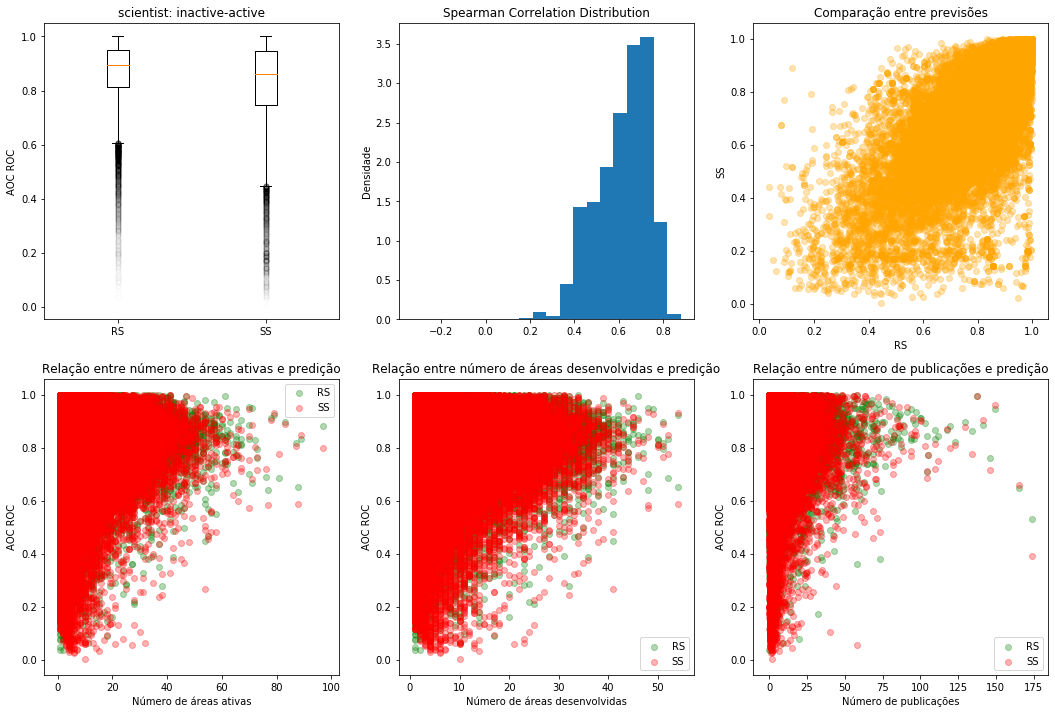

Valor mínimo [0.03610108303249099, 0.0034364261168384758]
Fração menor que 0.5 [0.021794109924128304, 0.04832847330670684]
Fração que foi melhor [0.6395748973866416, 0.34428336488895644]
Fração que foi melhor, acima de 0.5 [0.630023087938744, 0.35292398515357865]


In [9]:
accuracy('scientist', 'inactive-active')

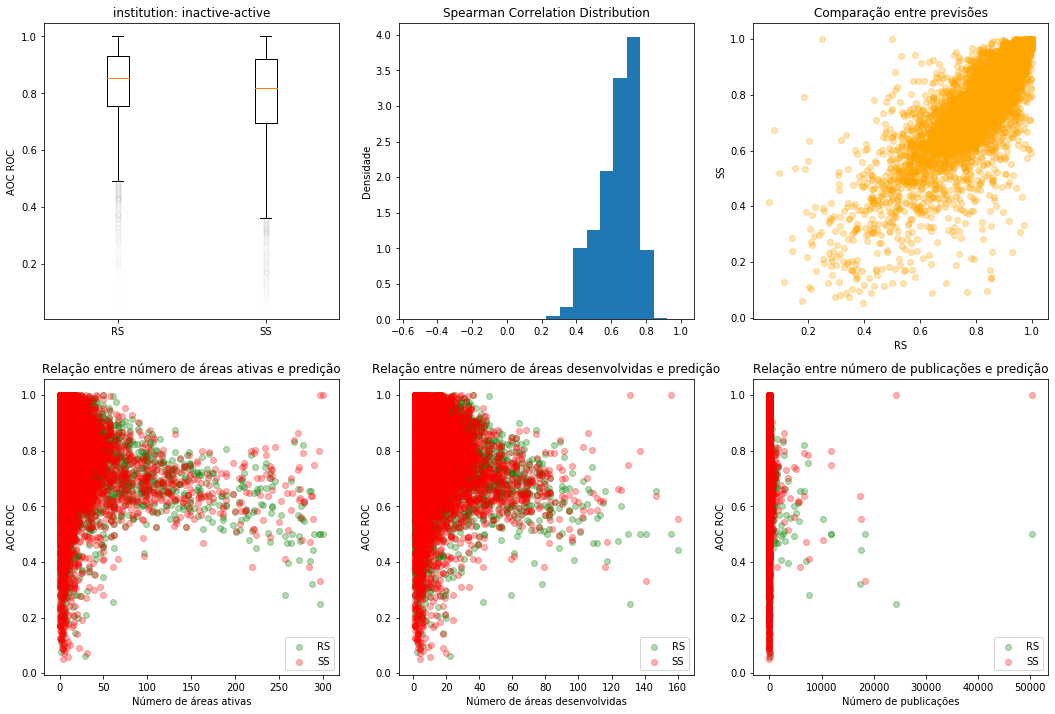

Valor mínimo [0.0625, 0.0515873015873016]
Fração menor que 0.5 [0.035955385970061635, 0.06530672145582624]
Fração que foi melhor [0.6439683005576754, 0.3444379219254476]
Fração que foi melhor, acima de 0.5 [0.6341579448144624, 0.353314303837615]


In [10]:
accuracy('institution', 'inactive-active')

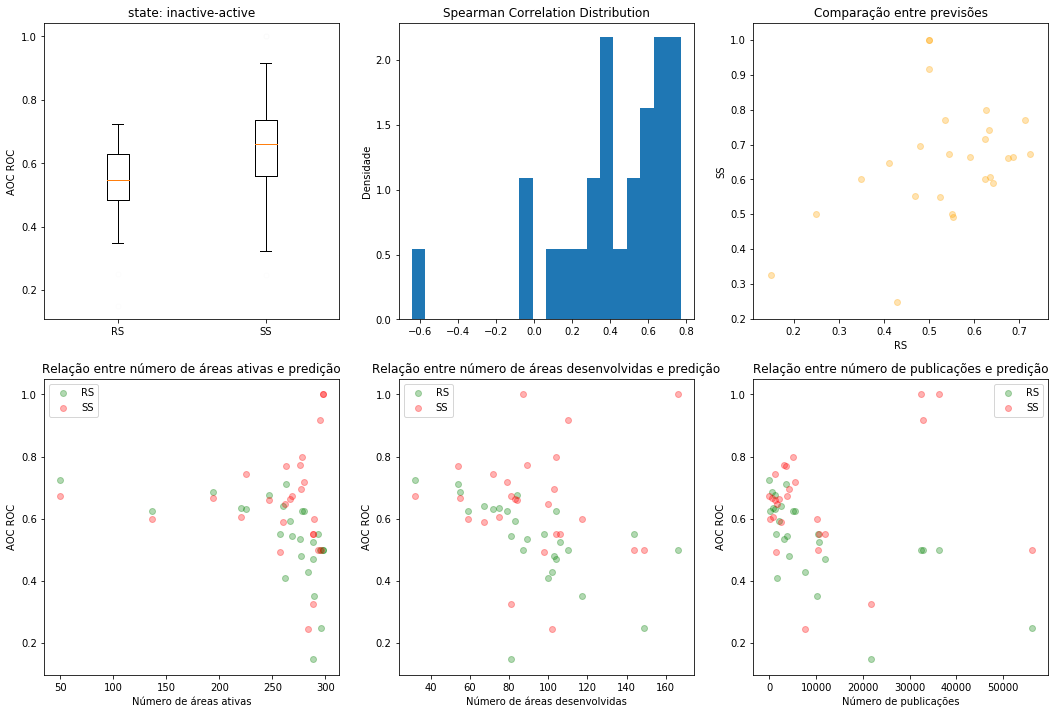

Valor mínimo [0.15000000000000002, 0.24675324675324675]
Fração menor que 0.5 [0.2692307692307692, 0.11538461538461539]
Fração que foi melhor [0.34615384615384615, 0.6538461538461539]
Fração que foi melhor, acima de 0.5 [0.42857142857142855, 0.5714285714285714]


In [11]:
accuracy('state', 'inactive-active')

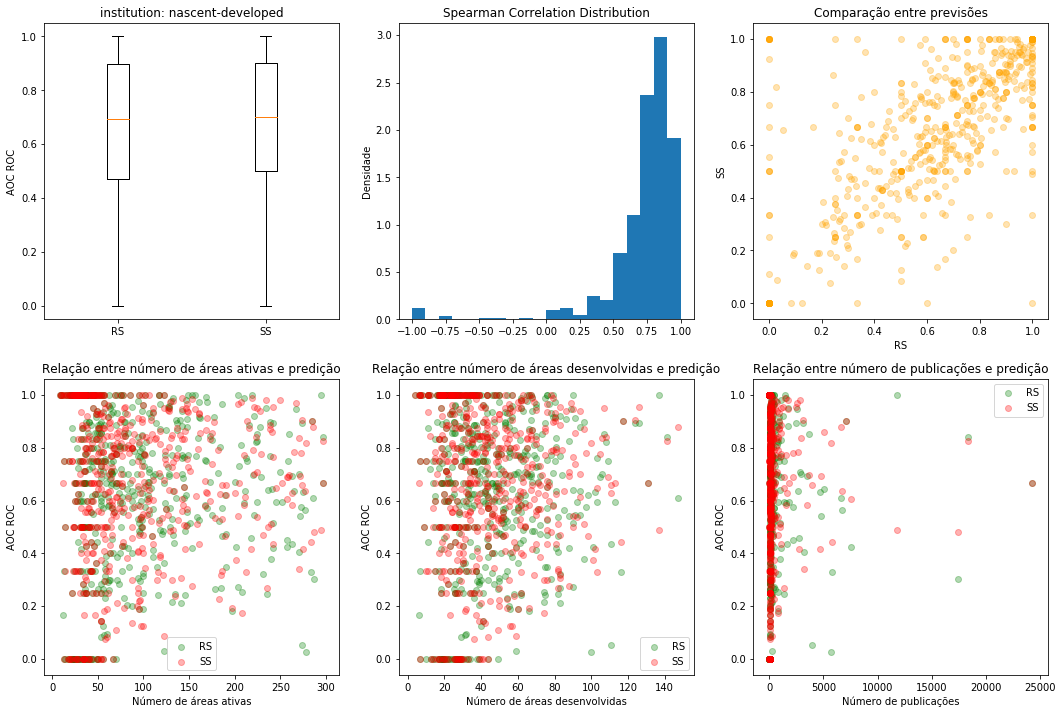

Valor mínimo [0.0, 0.0]
Fração menor que 0.5 [0.26480836236933797, 0.23693379790940766]
Fração que foi melhor [0.38153310104529614, 0.3693379790940767]
Fração que foi melhor, acima de 0.5 [0.4, 0.3277777777777778]


In [12]:
accuracy('institution', 'nascent-developed')

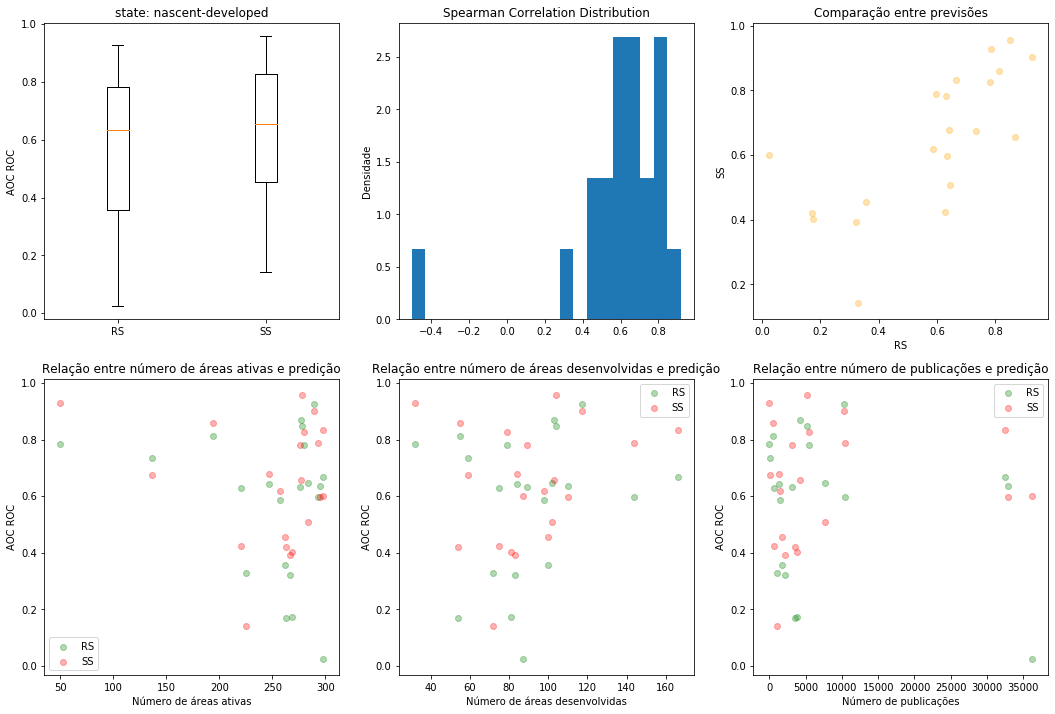

Valor mínimo [0.025000000000000022, 0.14285714285714285]
Fração menor que 0.5 [0.2857142857142857, 0.2857142857142857]
Fração que foi melhor [0.3333333333333333, 0.6666666666666666]
Fração que foi melhor, acima de 0.5 [0.35714285714285715, 0.6428571428571429]


In [13]:
accuracy('state', 'nascent-developed')

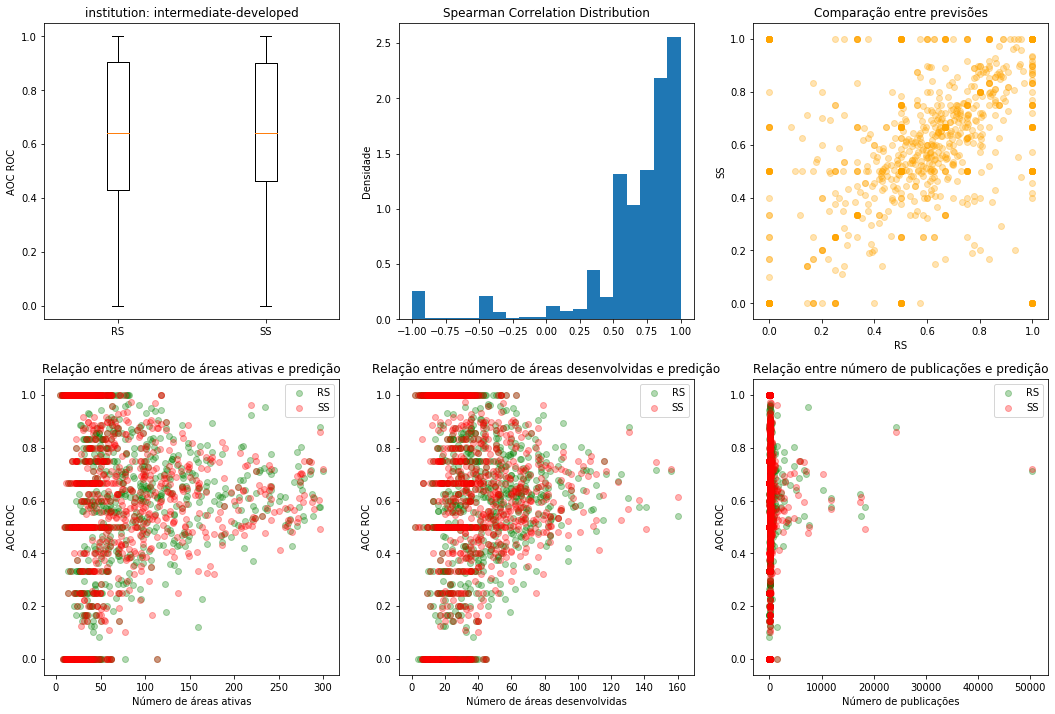

Valor mínimo [0.0, 0.0]
Fração menor que 0.5 [0.28205128205128205, 0.2744539411206078]
Fração que foi melhor [0.35327635327635326, 0.315289648622982]
Fração que foi melhor, acima de 0.5 [0.3435251798561151, 0.25719424460431656]


In [14]:
accuracy('institution', 'intermediate-developed')

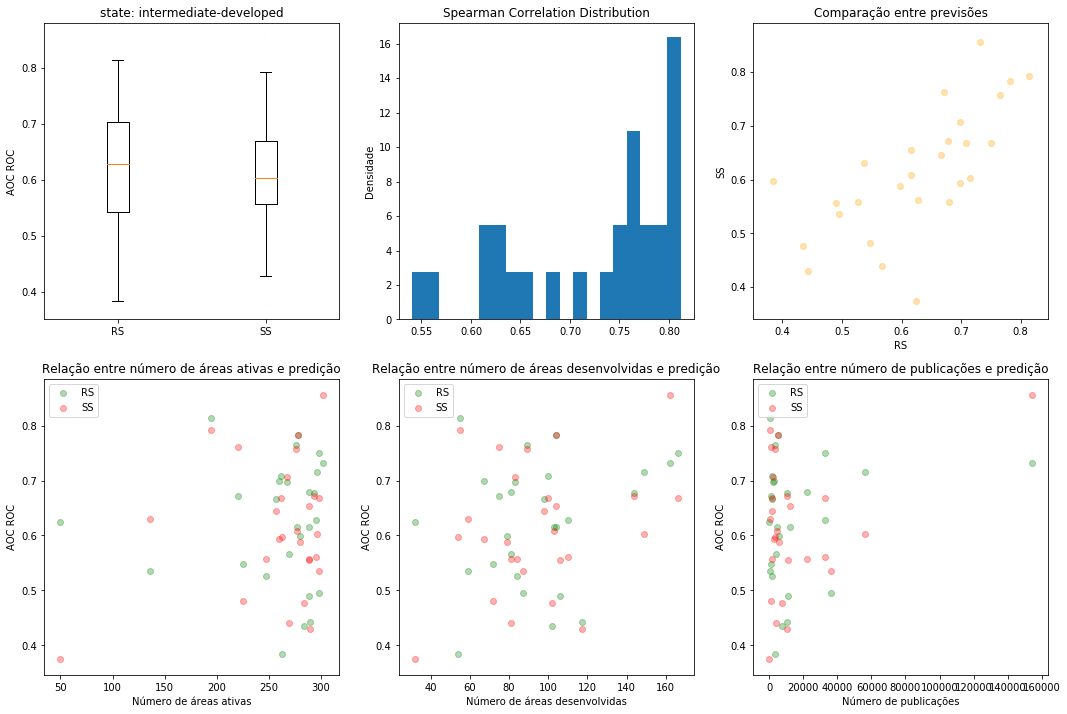

Valor mínimo [0.3835978835978836, 0.375]
Fração menor que 0.5 [0.18518518518518517, 0.18518518518518517]
Fração que foi melhor [0.5925925925925926, 0.4074074074074074]
Fração que foi melhor, acima de 0.5 [0.631578947368421, 0.3684210526315789]


In [15]:
accuracy('state', 'intermediate-developed')